In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

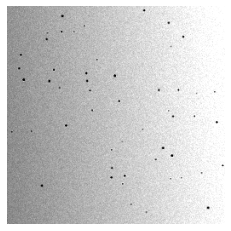

In [8]:
im_size_width, im_size_height, radius1, radius2 = 256, 256, 0.17e-6, 0.3e-6



moving_plankton1 = moving_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius1, label=0, diffusion_constant_coeff=1)

stationary_plankton1 = stationary_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius1, label=-1)

moving_plankton2 = moving_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius2, label=1, diffusion_constant_coeff=13)

stationary_plankton2 = stationary_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius2, label=-1)

sequential_moving_plankton1 = Sequential(
    moving_plankton1, position=get_position_moving_plankton)

sequential_stationary_plankton1 = Sequential(
    stationary_plankton1, position=get_position_stationary_plankton)

sequential_moving_plankton2 = Sequential(
    moving_plankton2, position=get_position_moving_plankton)

sequential_stationary_plankton2 = Sequential(
    stationary_plankton2, position=get_position_stationary_plankton)

gradient_amp=1
microscope = plankton_brightfield(im_size_height, im_size_width, gradient_amp)

no_of_moving_plankton1 = lambda: np.random.randint(10, 20)
no_of_stationary_plankton1 = lambda: np.random.randint(10, 20)
no_of_moving_plankton2 = lambda: np.random.randint(10, 20)
no_of_stationary_plankton2 = lambda: np.random.randint(10, 20)

sample = sequential_moving_plankton1**no_of_moving_plankton1 + \
sequential_stationary_plankton1**no_of_stationary_plankton1 + \
sequential_moving_plankton2**no_of_moving_plankton2 + \
sequential_stationary_plankton2**no_of_stationary_plankton2


noise_amp, norm_min, norm_max = 2, -0.2, 1.2
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)
sequence_length = 3
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)
imaged_particle_sequence.update()
imaged_particle_sequence.plot(cmap='gray');

label_function = get_target_sequence

batch_function = create_custom_batch_function(imaged_particle_sequence, 
                                              outputs=[0, 1, 2], 
                                              function_img=[normalize_image])


In [9]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    imaged_particle_sequence,
    get_target_sequence,
    batch_function,
    batch_size=8,
    min_data_size=128,
    max_data_size=512
    )

In [10]:
no_of_inputs, no_of_outputs = 3, 3
model = generate_unet(None, None, no_of_inputs, no_of_outputs)
model = train_model_early_stopping(model, generator, patience=10, 
                                   epochs=1000, steps_per_epoch=10)

Generating 128 / 128 samples before starting training
Epoch 1/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.0029
Epoch 2/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.0028
Epoch 3/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.0027
Epoch 4/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.0025
Epoch 5/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.0022
Epoch 6/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.0016
Epoch 7/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0013
Epoch 8/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0012
Epoch 9/1000
10/10 [==============================] - 1s 68ms/step - loss: 9.1054e-04
Epoch 10/1000
10/10 [==============================] - 1s 67ms/step - loss: 7.0996e-04
Epoch 11/1000
10/10 [==============================] - 1s 70ms/step - loss: 6.6227e-04
Epoch 12/1000
10/10 [=========

In [46]:
# save_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\models\\sequence_len3.keras'
# model.save(save_path_model)

In [3]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\Raw_output\\models\\sequence_len3.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

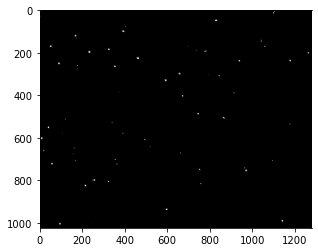

In [4]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\raw output'
im_stack = get_image_stack(
    outputs=[0, 1, 2], 
    folder_path=folder_path, 
    frame_im0=20, 
    im_size_width=1280, 
    im_size_height=1024,
    im_resize_width=1280, 
    im_resize_height=1024,
    function_img=[])

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,2]>0.8, cmap='gray')

In [5]:
positions = extract_positions(
    no_of_frames=48, 
    outputs=[0, 1, 2], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=1280, 
    im_size_height=1024,
    im_resize_width=1280, 
    im_resize_height=1024,
    model=model, 
    layer=2, 
    value_threshold=0.8,
    function_img=[])


In [6]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=25, time_threshold = 5, extrapolate=True)
list_of_plankton = interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=0)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.07, list_of_plankton=list_of_plankton)

[53. 53. 55. 54. 54. 52. 53. 54. 59. 62. 58. 57. 61. 59. 55. 58. 63. 57.
 57. 58. 58. 60. 59. 63. 62. 63. 71. 68. 68. 59. 58. 65. 63. 62. 63. 59.
 59. 61. 66. 69. 64. 58. 60. 66. 67. 62. 59. 55.]
[ 0.  0. 25. 19. 15. 16.  8.  9. 12.  7.  9.  2.  4.  7.  1.  2.  3.  2.
  3.  1.  2.  3.  3.  2.  2.  2.  3.  0.  1.  0.  2.  3.  1.  1.  0.  1.
  0.  0.  0.  2.  0.  0.  1.  1.  2.  1.  1. 18.]


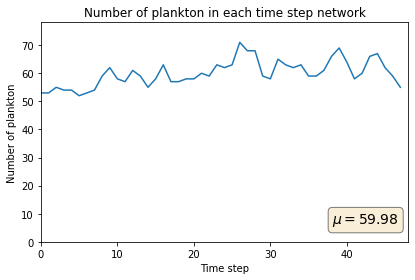

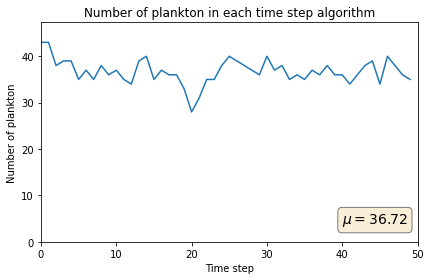

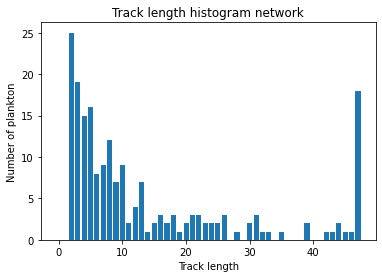

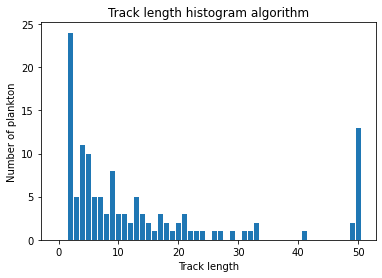

In [8]:
import xml.etree.ElementTree as ET

def get_found_plankton_from_xml(path, no_timesteps, var_str):
    tree = ET.parse(path)
    root = tree.getroot()


    found_plankton_at_timestep = np.zeros(no_timesteps)

    for particle in root.iter():
        my_dict = particle.attrib
        if var_str in my_dict:
            found_plankton_at_timestep[int(float(my_dict[var_str]))] += 1
    return found_plankton_at_timestep


found_plankton_at_timestep = get_found_plankton_at_timestep(plankton_track)     
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step network')
print(found_plankton_at_timestep)


path = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\raw output_Tracks.xml"
no_timesteps = 51
found_plankton_at_timestep = get_found_plankton_from_xml(path, no_timesteps, 't')
plot_statistics(found_plankton_at_timestep, 'Number of plankton in each time step algorithm')


track_durations = get_track_durations(plankton_track)
plot_bars(track_durations, 'Track length histogram network')
print(track_durations)

track_durations = get_found_plankton_from_xml(path, no_timesteps, 'nSpots')
plot_bars(track_durations, 'Track length histogram algorithm')


In [44]:
# plot_and_save_track(no_of_frames=48,
#                     plankton_track=plankton_track,
#                     plankton_dont_track=plankton_dont_track,
#                     folder_path=folder_path,
#                     frame_im0=1,
#                     save_images=1,
#                     show_plankton_track = True,
#                     show_plankton_dont_track = 0,
#                     show_numbers_track = 0,
#                     show_numbers_dont_track = 0,
#                     show_numbers_specific_plankton = False,
#                     show_specific_plankton = False,
#                     specific_plankton = None,
#                     im_size_width=1280, 
#                     im_size_height=1024,
#                     color_plankton_track = 'b',
#                     color_plankton_dont_track = 'r',
#                     color_specific_plankton = 'w',
#                     save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\seq_len_3_with_statioanry',
#                     frame_name = 'track',
#                     file_type = '.jpg')

In [45]:
# make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\seq_len_3_with_statioanry', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output\\seq_len_3_with_statioanry.avi', 
#            fps=7, 
#            no_of_frames=48)